<a href="https://colab.research.google.com/github/tsakailab/DeepLS/blob/main/sandbox/Data_Science_Bowl_RPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

前景である物体の存在が疎であり，背景がすべて同じ様相の顕微鏡画像についてRPCAを実施する

In [168]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [169]:
!kaggle competitions download -c data-science-bowl-2018

stage1_sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
stage2_test_final.zip: Skipping, found more recently modified local copy (use --force to force download)
stage1_train_labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
stage1_solution.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
stage1_train.zip: Skipping, found more recently modified local copy (use --force to force download)
stage1_test.zip: Skipping, found more recently modified local copy (use --force to force download)
stage2_sample_submission_final.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [170]:
!unzip -qud stage1_train stage1_train.zip
!unzip -qud stage1_test stage1_test.zip

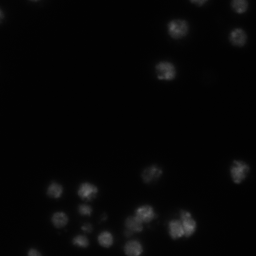

In [171]:
from PIL import Image
datafolder_path = "./stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/"

Image.open(datafolder_path + "00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png")

In [172]:
from torch.utils.data import DataLoader, Dataset, random_split
import os
from torchvision import transforms, utils
from PIL import Image
import numpy as np
import torch
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from time import time
from skimage.filters import threshold_multiotsu
from skimage.filters import threshold_otsu
import matplotlib

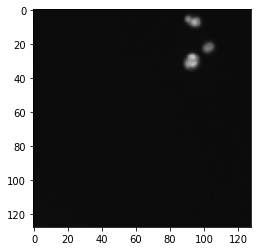

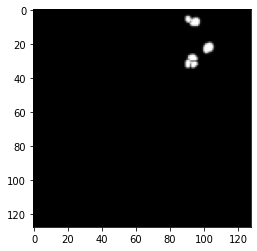

In [204]:
transform = transforms.Compose([
    # transforms.Grayscale(),
    transforms.Normalize(mean=0.5, std=0.5),
])
class Nuclie_data(Dataset):
    def __init__(self,path):
        self.path = path
        self.folders = os.listdir(path)
        # self.transforms = get_transforms(0.5, 0.5)
        self.transforms = transform
        self.resize = transforms.Compose([
            transforms.Resize((128, 128))
        ])
    
    def __len__(self):
        return len(self.folders)
            
    
    def __getitem__(self,idx):
        image_folder = os.path.join(self.path,self.folders[idx],'images/')
        mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
        image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
        
        img = Image.open(image_path)
        # print(np.array(img).shape)
        img = self.resize(img)
        img = torch.tensor(np.array(img)[:,:, :3]).float().permute(2,0,1)
        img = img/255
        if torch.histogram(img, bins=10)[0].argmax() > 4:
            img = 1 - img

        mask = torch.tensor(self.get_mask(mask_folder, 128, 128)).float().permute(2,0,1)

        # augmented = self.transforms(img)
        return (img,mask) 

    def get_mask(self,mask_folder,IMG_HEIGHT, IMG_WIDTH):
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_ in os.listdir(mask_folder):
            mask_ = Image.open(os.path.join(mask_folder,mask_))
            mask_ = self.resize(mask_)
            mask_ = np.array(mask_)
            mask_ = np.expand_dims(mask_, -1)
            mask = np.maximum(mask, mask_)
        return mask
base_dir = './stage1_train/'
data = Nuclie_data(base_dir)
import matplotlib.pyplot as plt
for i in range(1):
    ret = data.__getitem__(i)
    fig = plt.figure()
    plt.imshow(ret[0].permute(1,2,0))
    fig = plt.figure()
    plt.imshow(ret[1][0], cmap="gray")
    

In [190]:
#@title dataset numpy
imgs = []
threshold = 0.4
for f in glob.glob("./stage1_train/*/images/*png"):
  img = Image.open(f).convert("L")
  print(f)
  img = img.resize((100, 100)) # If WBC
  img = np.array(img)
  img = img / 255
#   if img.mean() > 0.4:
#       img = 1 - img
  # img = (img - img.min()) / (img.max() - img.min())
  imgs.append(img)

# Fake Images
# imgs = []
# for i in range(50):
#   back_img = np.zeros((180, 180))
#   img = cv2.circle(back_img, (np.random.randint(180), np.random.randint(180)), radius=20, color=0.6, thickness=-1)
#   img = cv2.circle(img, (np.random.randint(30, 180-30), np.random.randint(30, 180-30)), radius=30, color=0.8, thickness=-1)
#   img = cv2.circle(img, (np.random.randint(180), np.random.randint(180)), radius=2, color=0.9, thickness=-1)
#   img = img*-1
#   img = (img - img.min()) / (img.max() - img.min())
#   imgs.append(img)
imgs_arr = np.array(imgs)
imgs_arr.shape

./stage1_train/93cfd412c7de5210bbd262ec3a602cfea65072e9272e9fce9b5339a5b9436eb7/images/93cfd412c7de5210bbd262ec3a602cfea65072e9272e9fce9b5339a5b9436eb7.png
./stage1_train/65c8527c16a016191118e8adc3d307fe3a73d37cbe05597a95aebd75daf8d051/images/65c8527c16a016191118e8adc3d307fe3a73d37cbe05597a95aebd75daf8d051.png
./stage1_train/947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050/images/947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050.png
./stage1_train/57bd029b19c1b382bef9db3ac14f13ea85e36a6053b92e46caedee95c05847ab/images/57bd029b19c1b382bef9db3ac14f13ea85e36a6053b92e46caedee95c05847ab.png
./stage1_train/c0f172831b8017c769ff0e80f85b096ac939e79de3d524e0826fbb95221365da/images/c0f172831b8017c769ff0e80f85b096ac939e79de3d524e0826fbb95221365da.png
./stage1_train/c8ca945abc29d262a5525e4c2585541bba33fa77c86a47c94575d8e5b54c83fb/images/c8ca945abc29d262a5525e4c2585541bba33fa77c86a47c94575d8e5b54c83fb.png
./stage1_train/1a75de9e11303142864efed27e69ea1960dbd82ca910de221

(670, 100, 100)

In [205]:
imgs = []
masks = []
from tqdm import tqdm
bar = tqdm(total=670, position=0, leave=True)
for i in range(670):
    ret = data.__getitem__(i)
    imgs.append(ret[0])
    masks.append(ret[1])
    bar.update(1)
bar.close()


  0%|          | 0/670 [00:17<?, ?it/s]

100%|██████████| 670/670 [01:02<00:00, 10.74it/s]


In [206]:
imgs = torch.stack(imgs)
masks = torch.stack(masks)

print(imgs.shape)
print(masks.shape)

torch.Size([670, 3, 128, 128])
torch.Size([670, 1, 128, 128])


In [207]:
# RGB -> grayscale変換するone by one2次元畳み込みフィルタを定義しています．
rgb2gray = torch.nn.Conv2d(3,1,1,padding=0, bias=False)#[*,3,1,1]
print(rgb2gray.weight)
rgb2gray.weight = torch.nn.Parameter(torch.tensor([0.2989, 0.5870, 0.1140]).unsqueeze(0).unsqueeze(-1).unsqueeze(-1))
print(rgb2gray.weight)

imgs = rgb2gray(imgs).detach()

Parameter containing:
tensor([[[[ 0.2051]],

         [[ 0.4259]],

         [[-0.1431]]]], requires_grad=True)
Parameter containing:
tensor([[[[0.2989]],

         [[0.5870]],

         [[0.1140]]]], requires_grad=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


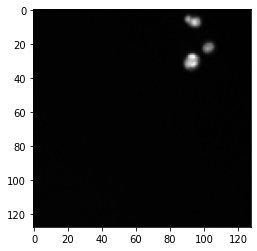

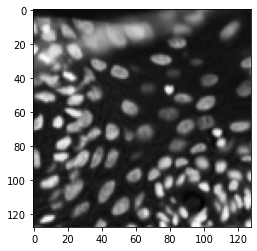

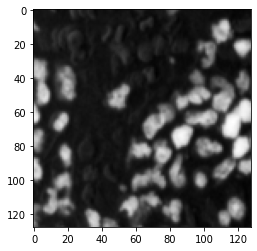

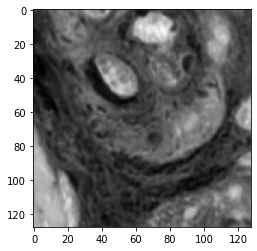

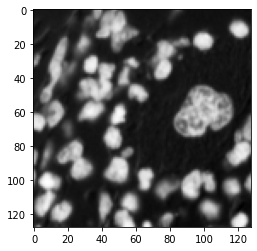

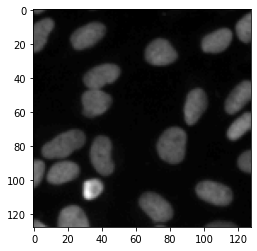

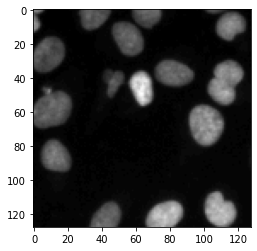

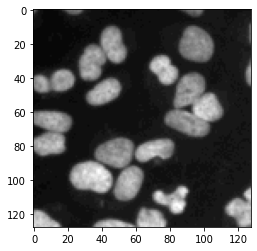

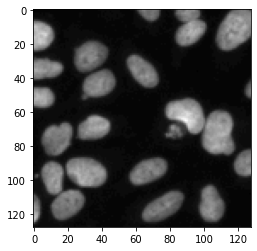

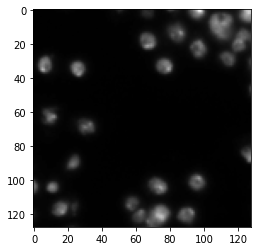

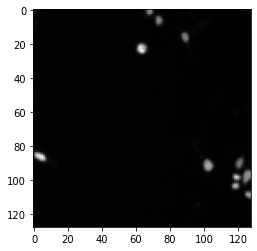

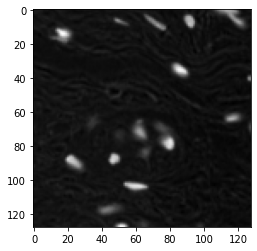

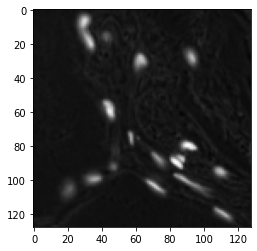

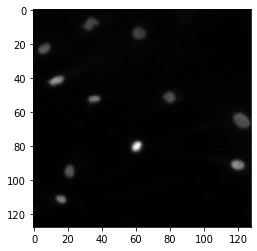

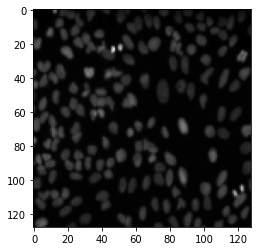

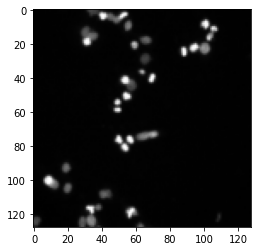

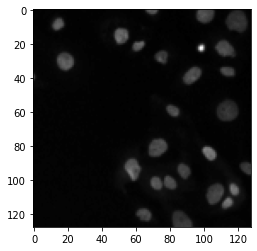

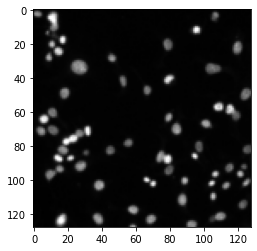

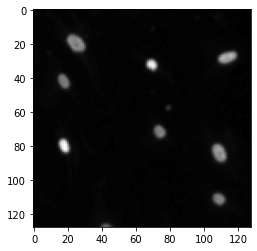

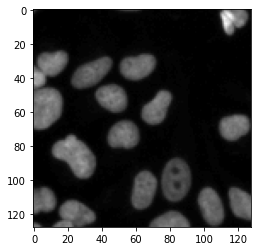

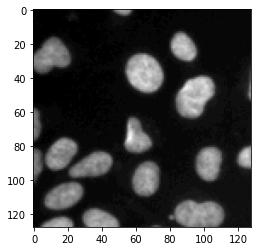

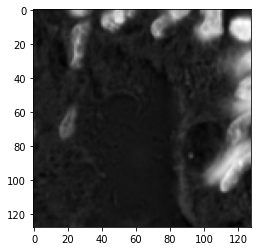

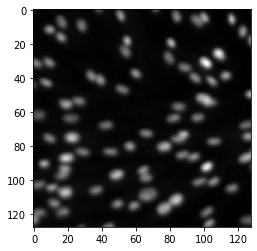

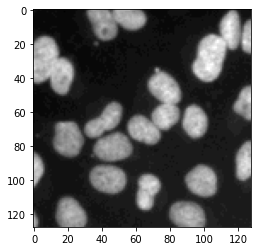

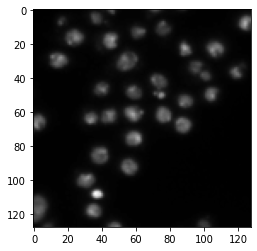

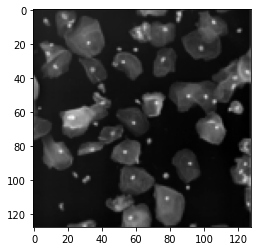

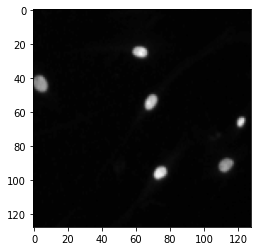

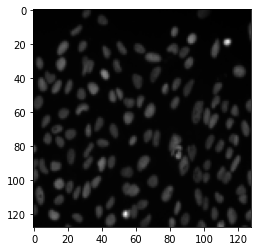

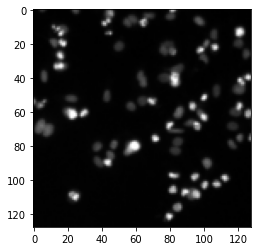

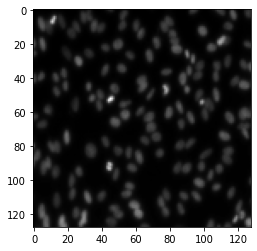

In [211]:
for i in range(30):
    fig = plt.figure()
    plt.imshow(imgs[i][0], cmap="gray")

In [212]:
imgs_arr = np.array(imgs.permute(0, 2, 3, 1))
imgs_arr.shape

(670, 128, 128, 1)

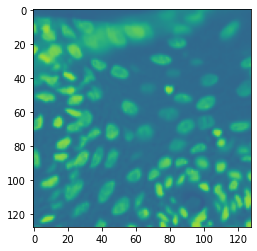

In [213]:
plt.imshow(imgs_arr[1][:,:,0], vmin=0, vmax=1)
plt.show()

(670, 16384)


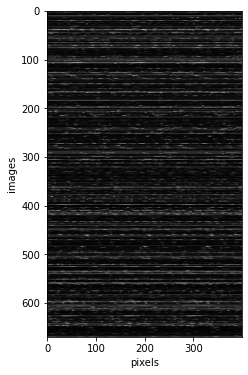

In [214]:
DDseq = np.reshape(imgs_arr, (len(imgs_arr), -1))
print(DDseq.shape)
plt.figure(figsize=(18, 6))
plt.imshow(DDseq[:, :400], cmap="gray")
plt.xlabel("pixels")
plt.ylabel("images")
plt.show()

(array([1.6182e+04, 4.8000e+01, 2.8000e+01, 2.0000e+01, 3.5000e+01,
        1.9000e+01, 2.0000e+01, 1.3000e+01, 1.2000e+01, 7.0000e+00]),
 array([0.03921176, 0.11567471, 0.19213766, 0.2686006 , 0.34506357,
        0.4215265 , 0.49798945, 0.5744524 , 0.6509153 , 0.7273783 ,
        0.80384123], dtype=float32),
 <a list of 10 Patch objects>)

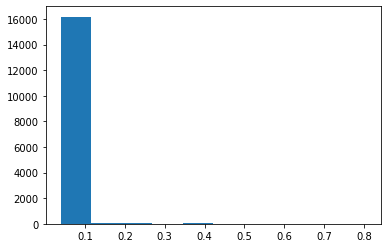

In [215]:
plt.hist(DDseq[0])

(array([373., 151.,  26.,  17.,  10.,  25.,  28.,  22.,  14.,   4.]),
 array([0.00380869, 0.06043307, 0.11705744, 0.17368183, 0.2303062 ,
        0.28693056, 0.34355494, 0.40017933, 0.45680368, 0.5134281 ,
        0.57005244], dtype=float32),
 <a list of 10 Patch objects>)

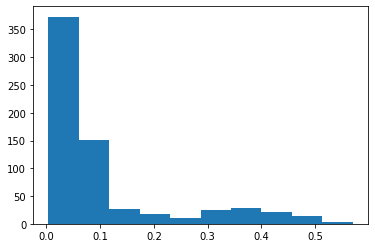

In [216]:
plt.hist(DDseq.mean(1))

In [217]:
import torch

DD = torch.from_numpy(DDseq).float()
# DD = torch.from_numpy(D.T[:200].T).float()

u, s, vh = torch.linalg.svd(DD, full_matrices=False)
print(u.shape)
print(s.shape)
print(vh.shape)

torch.Size([670, 670])
torch.Size([670])
torch.Size([670, 16384])


Nuclear norm of a
sum of s:  5591.89697265625
nuc norm a:  5591.90380859375


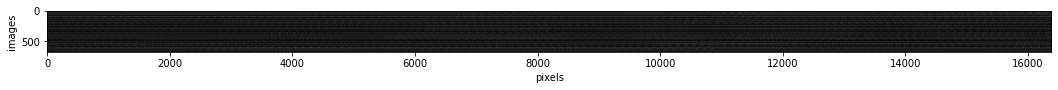

In [218]:
print("Nuclear norm of a")
print("sum of s: ", torch.linalg.norm(s, ord=1).item())
print("nuc norm a: ", torch.linalg.norm(DD, ord="nuc").item())
DD_re = torch.matmul(torch.matmul(u, s.diag()), vh)

plt.figure(figsize=(18, 6))
plt.imshow(DD_re, cmap="gray")
plt.ylabel("images")
plt.xlabel("pixels")
plt.show()

In [219]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
### Definitions

soft = lambda z, th: z.sign() * (z.abs() - th).max(torch.tensor(0., device=device))

## L1 loss
class L1LossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        ctx.save_for_backward(input, lw)
        return torch.sum(torch.abs(input)*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw = ctx.saved_tensors
        grad_input = grad_output.clone()
        return (input - soft(input, lw)) * grad_input, torch.abs(input) * grad_input

class L1Loss(torch.nn.Module):
    def __init__(self, lw=torch.tensor(1.0, device=device)):
        super(L1Loss, self).__init__()
        self.fn = L1LossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)

## Nuclear loss
class NuclearLossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        u, s, v = torch.svd(input)
        ctx.save_for_backward(input, lw, u, s, v)
        return torch.sum(s*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw, u, s, v = ctx.saved_tensors
        grad_input = grad_output.clone()
        svt_input = torch.matmul(torch.matmul(u, torch.diag_embed(soft(s,lw))), torch.transpose(v, -2, -1))
        return (input - svt_input) * grad_input, s * grad_input

class NuclearLoss(torch.nn.Module):
    def __init__(self, lw=torch.tensor(1.0, device=device)):
        super(NuclearLoss, self).__init__()
        self.fn = NuclearLossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)


# Random Projection
class RandomProjection(torch.nn.Module):
    def __init__(self, dx, dp, requires_grad=False):
      """
      If requires_grad = True, learnable random matrix R will be orthogonal matrix.
      """
      super().__init__()
      self.R = torch.randn(dp, dx, requires_grad=requires_grad, device=device) / torch.sqrt(torch.tensor(dp))
        
    def forward(self, input):
      return self.R @ input.t()

cuda


In [220]:
ls = 1./np.sqrt(max(m,n))
print(ls)

0.08838834764831843


0.0005
16384 1638
[ 20/200]: loss = 1088.2368,  
[ 40/200]: loss = 725.2120,  
[ 60/200]: loss = 670.5327,  
[ 80/200]: loss = 645.7983,  
[100/200]: loss = 628.1097,  
[120/200]: loss = 614.8107,  
[140/200]: loss = 604.8732,  
[160/200]: loss = 597.2012,  
[180/200]: loss = 591.2526,  
[200/200]: loss = 586.3328,  
96707.24511146545  [ms]


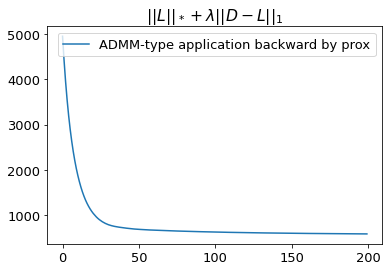

In [292]:
from time import time
### Algorithm

D = DD[:].clone().float().to(device)

m, n, _ = imgs_arr[0].shape

# Hyperparameters
# ls = 1./np.sqrt(max(m,n))
# ls = 7.2e-3
# ls = 5e-3
# ls = 1e-3 # 0.5934804677963257
ls = 5e-4 # 0.596169114112854
# ls = 1e-10 # 0.5810257196426392
# ls = 0 # 0.58101886510849
# ls = 1e-2
ln = 1.
le = 1e-6
print(ls)
# Using L1Loss with prox
nucloss = NuclearLoss(lw=torch.tensor(ln))
l1loss = L1Loss(lw=torch.tensor(ls))
l2loss = lambda x: torch.sum(x**2)

# Random Projection Module
dx, dp = D.shape[1], int(D.shape[1]*0.1)
print(dx, dp)
rp = RandomProjection(dx, dp, requires_grad=True)

L, S, E, Y = 0, 0, 0, 0

t = time()
num_iter = 200
display_step = num_iter // 10
history_loss_inexact = []
lr =1e0

for iter in range(num_iter):
    total_loss = 0.

    X = (D-S-E+Y).clone().detach().requires_grad_(True)
    loss = nucloss(X)
    optimizer = torch.optim.SGD([X], lr = lr)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    L = X.detach()

    X = (D-L-E+Y).clone().detach().requires_grad_(True)
    loss = l1loss(X)
    optimizer = torch.optim.SGD([X], lr = lr)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    S = X.detach()

    X = ((D-L-S+Y) * le).clone().detach().requires_grad_(True)
    loss = l2loss(X)
    optimizer = torch.optim.SGD([X], lr = lr)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    E = X.detach()

    Y = Y + (D-L-S-E)

    total_loss = nucloss(L) + l1loss(D-L)

    history_loss_inexact.append(total_loss)
    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))

print((time()-t)*1000, ' [ms]')

plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
plt.legend()
plt.show()

In [293]:
#@title 4D arrayの画像・特徴マップを表示する関数を定義します．
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm as tsn


def plotImages(img_arr, lbl_arr, colors_arr=None, figsize=(8, 4), mag=2, mean=0., std =1.):

    if len(img_arr) <= min(figsize): rc = (1, len(img_arr))
    else: rc = (figsize[1], min(len(img_arr)//figsize[1], figsize[0]))
    fig, axes = plt.subplots(rc[0], rc[1], figsize=(rc[1]*mag, rc[0]*mag))
    if len(img_arr) != 1:
        axes = axes.flatten()
    else: 
        axes = [axes]
    if colors_arr is None: colors_arr = ['k']*len(lbl_arr)
    for img, lbl, c, ax in zip( img_arr, lbl_arr, colors_arr, axes):
        img = img.numpy().transpose((1,2,0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(lbl, color=c)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# plot feature maps
def plotFeaturemaps(maps, max_ch=12, top=None, figsize=(8, 3), mag=1):

    if maps.ndim == 1:
        plt.figure(figsize=figsize)
        plt.bar(np.arange(maps.shape[0]), maps, width=1.0)
        plt.tight_layout()
        plt.show()
        return

    if maps.ndim != 3: return
    # maps.shape = (ch, h, w)
    if top is not None:
        nmaps = min(top, maps.shape[0])
        nrows, ncols = 1, nmaps
        channels = np.argsort(-np.sum(np.abs(maps.reshape((maps.shape[0],-1))**2), axis=1))[:nmaps]
    else:
        nmaps = min(maps.shape[0], max_ch*max_ch)
        ncols = int(np.ceil(np.sqrt(nmaps)))
        nrows = int(np.floor(nmaps / ncols))
        nmaps = nrows * ncols
        channels = range(nmaps)

    norm = tsn(vmin=np.minimum(maps[:].min(),-1e-6), vcenter=0, vmax=np.maximum(maps[:].max(),1e-6)) # maps[channels]
    fig = plt.figure(figsize=(ncols*mag, nrows*mag))
    for ch in range(nmaps):
        ax1 = fig.add_subplot(nrows, ncols, ch+1)
        ax1.imshow(maps[channels[ch]], cmap='bwr_r', norm=norm)#, aspect='equal')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    plt.tight_layout()
    plt.show()

from matplotlib import cm as cmap
# x[H,W]
def toColorImg(x, cm='bwr_r'):
    maxpix = np.abs(x).max()
    norm = tsn(vmin=np.minimum(maxpix*-1,-1e-6), vcenter=0, vmax=np.maximum(maxpix,1e-6)) # maps[channels]
    sm = cmap.ScalarMappable(norm=norm, cmap=cm)
    return sm.to_rgba(x)[:,:,:3]
def iou_(y_pred,y):
    inputs = y_pred.reshape(-1)
    targets = y.reshape(-1)
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    smooth = 1    
    iou = (intersection + smooth)/(union + smooth)
    return iou

In [294]:
l = torch.reshape(L, (-1, imgs_arr[0].shape[0], imgs_arr[0].shape[1])).cpu().data.numpy()
s = torch.reshape(S, (-1, imgs_arr[0].shape[0], imgs_arr[0].shape[1])).cpu().data.numpy()
d = torch.reshape(D, (-1, imgs_arr[0].shape[0], imgs_arr[0].shape[1])).cpu().data.numpy()
e = torch.reshape(E, (-1, imgs_arr[0].shape[0], imgs_arr[0].shape[1])).cpu().data.numpy()

ious = []
ious_t = []

for i in range(len(D)):
  s_img = s[i]
  ss_img = np.abs(s_img)
  predict = torch.zeros((128, 128))
  thresh = threshold_otsu((ss_img*255).astype(np.uint8))
  predict[torch.tensor(ss_img)*255 > thresh] = 1
  mask = masks[i].clone()
  mask[mask != 0] = 1
  ious.append(iou_(torch.tensor(predict), mask))
  
  predict = torch.zeros((128, 128))
  predict[torch.tensor(ss_img)*255 > thresh/2] = 1
  ious_t.append(iou_(torch.tensor(predict), mask))

ious = torch.stack(ious)
ious_t = torch.stack(ious_t)

print(ious.mean(), ious.std())
print(ious_t.mean(), ious_t.std())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(0.6095) tensor(0.1341)
tensor(0.7506) tensor(0.2131)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


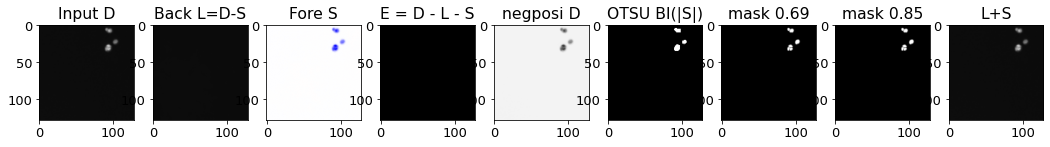

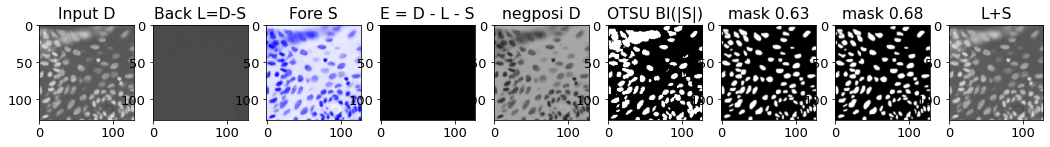

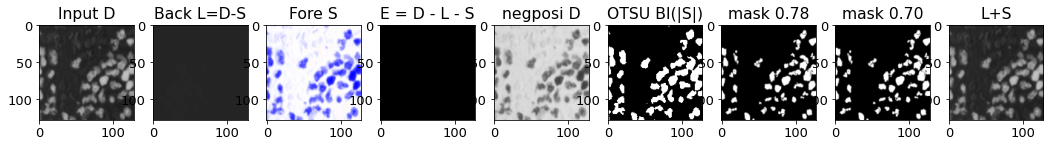

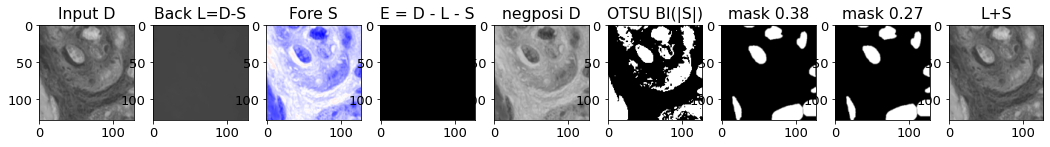

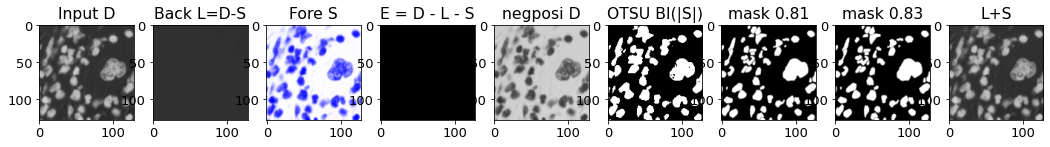

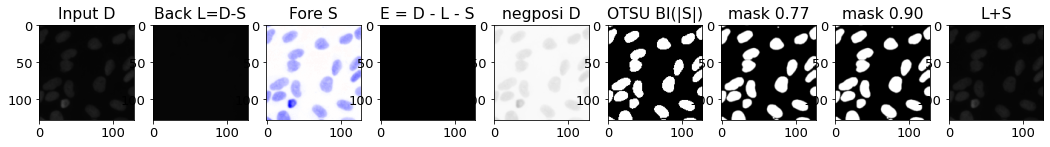

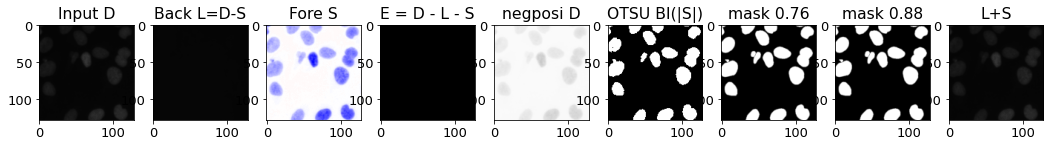

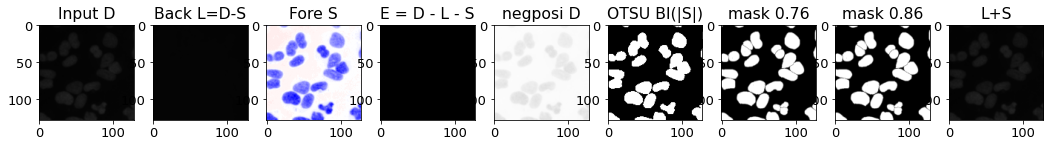

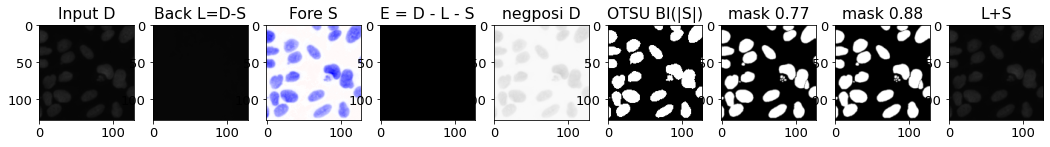

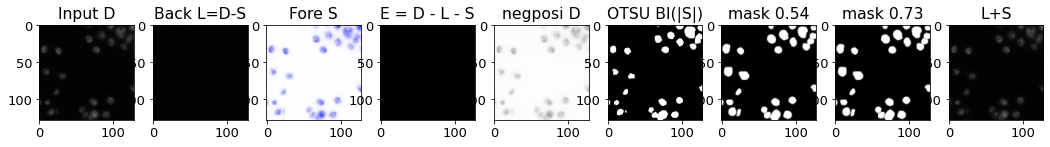

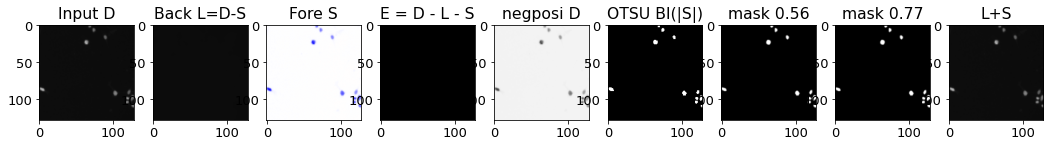

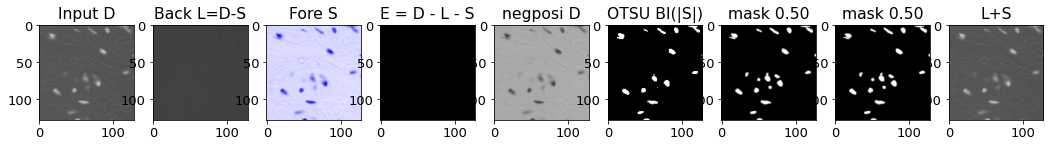

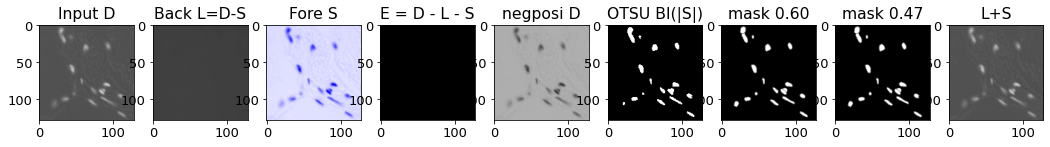

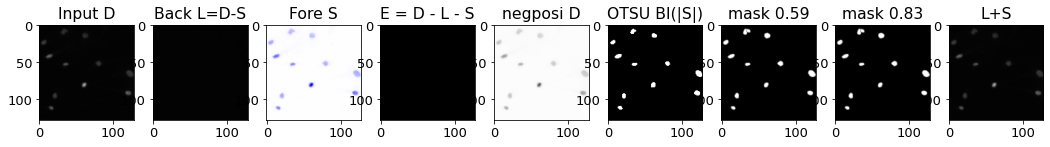

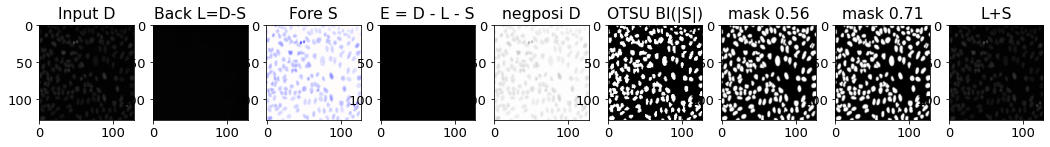

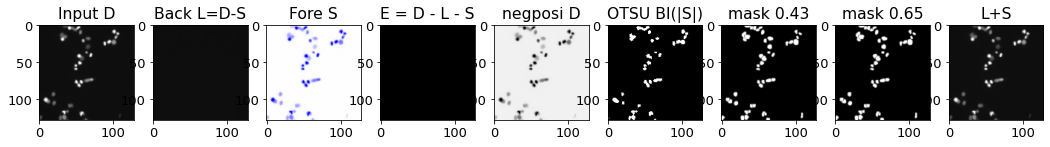

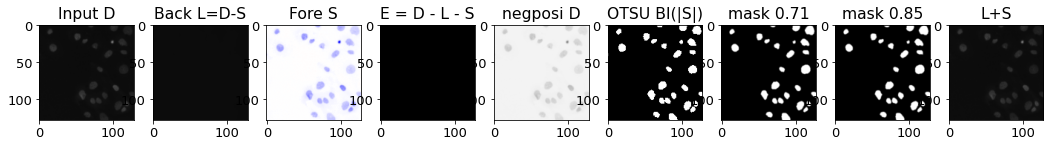

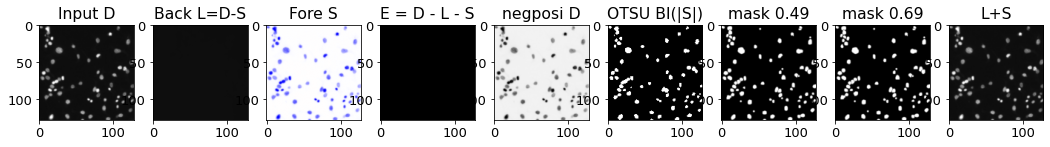

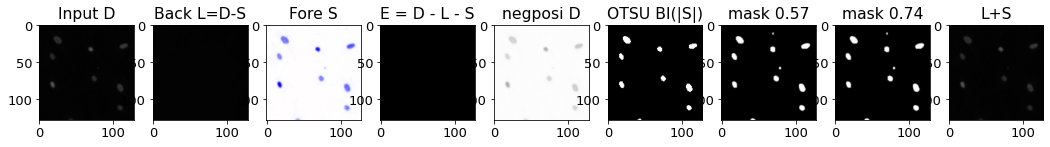

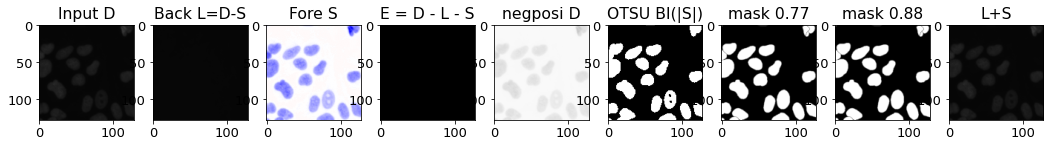

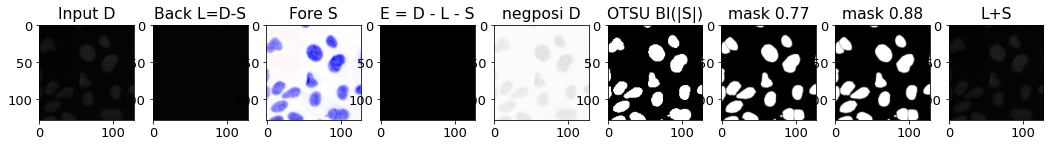

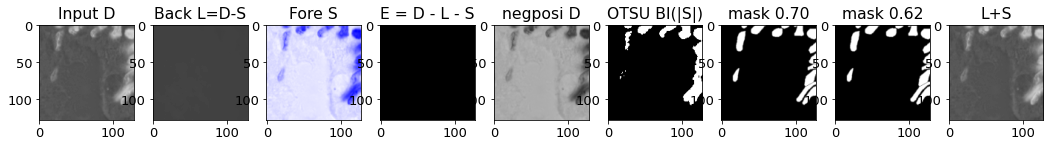

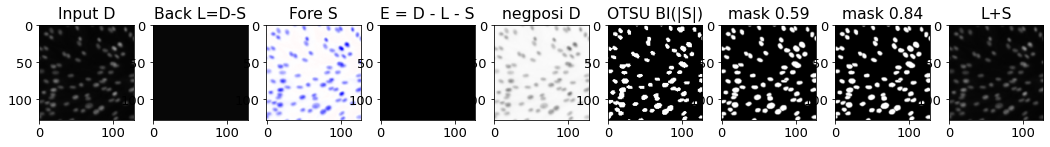

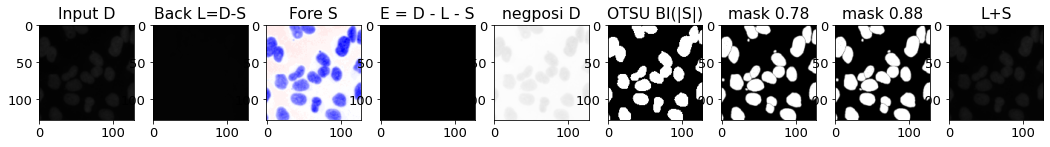

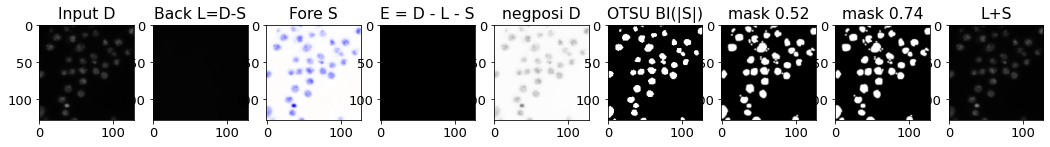

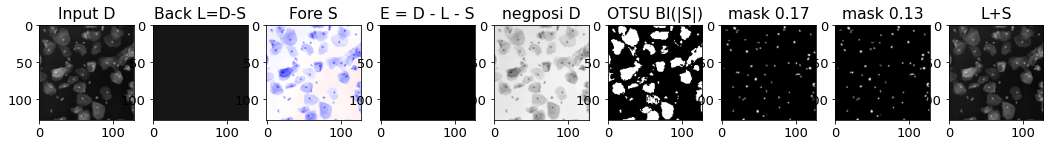

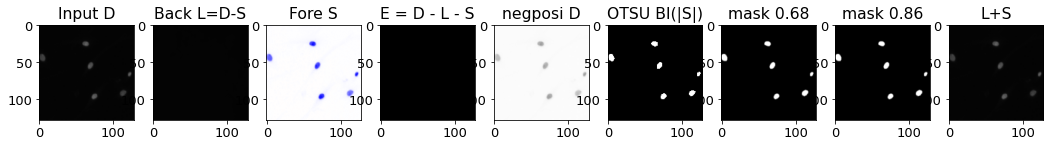

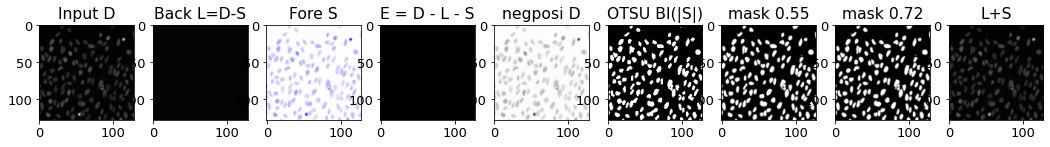

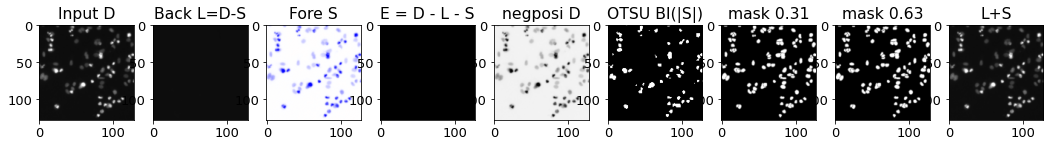

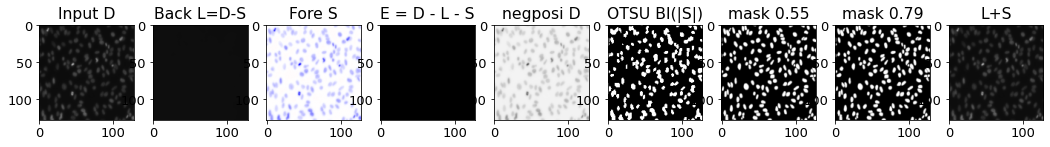

In [295]:
for i in range(30):
  fig, ax = plt.subplots(1, 9, figsize=(18, 8))
  d_img = d[i]
  ax[0].set_title("Input D")
  ax[0].imshow(d_img, cmap="gray", vmin=0, vmax=1)
  l_img = l[i]
  ax[1].set_title("Back L=D-S")
  ax[1].imshow(l_img,  cmap="gray", vmin=0, vmax=1)
  s_img = s[i]
  ax[2].set_title("Fore S")
  ax[2].imshow(toColorImg(s_img), cmap="gray", vmin=0, vmax=1)
  e_img = e[i]
  ax[3].set_title("E = D - L - S")
  ax[3].imshow(e_img, cmap="gray", vmin=0, vmax=1)

  ax[4].set_title("negposi D")
  ax[4].imshow(d_img*-1 + 1, cmap="gray", vmin=0, vmax=1)

  ss_img = np.abs(s_img)

  predict = torch.zeros((128, 128))
  thresh = threshold_otsu((ss_img*255).astype(np.uint8))
  predict[torch.tensor(ss_img)*255 > thresh] = 1
  ax[5].set_title("OTSU BI(|S|)")
  ax[5].imshow(predict, cmap="gray")
  mask = masks[i].clone()
  mask[mask != 0] = 1
  ax[6].set_title("mask {:.2f}".format(iou_(torch.tensor(predict), mask)))
  ax[6].imshow(masks[i][0], cmap="gray")

  predict = torch.zeros((128, 128))
  predict[torch.tensor(ss_img)*255 > thresh/2] = 1
  mask = masks[i].clone()
  mask[mask != 0] = 1
  ax[7].set_title("mask {:.2f}".format(iou_(torch.tensor(predict), mask)))
  ax[7].imshow(masks[i][0], cmap="gray")

  ax[8].set_title("L+S")
  ax[8].imshow(l_img+s_img, cmap="gray", vmin=0, vmax=1)
  # fig.colorbar(im)
  plt.show()

54.0


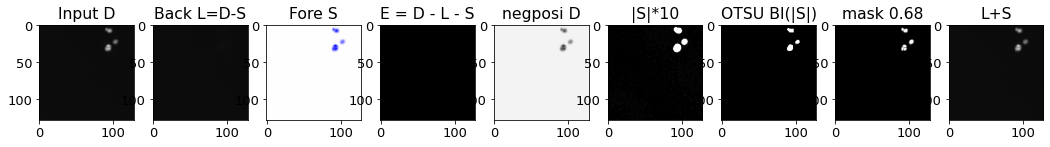

25.0


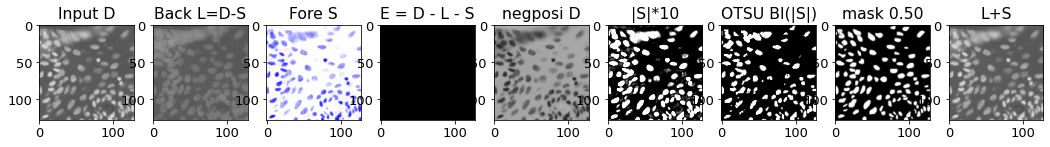

35.0


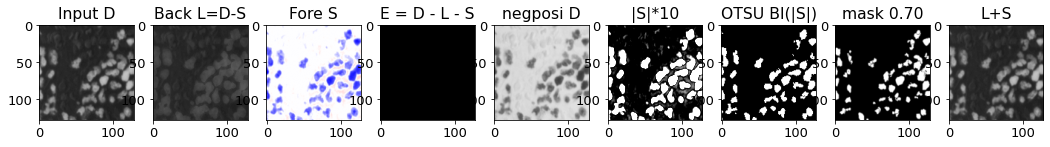

16.0


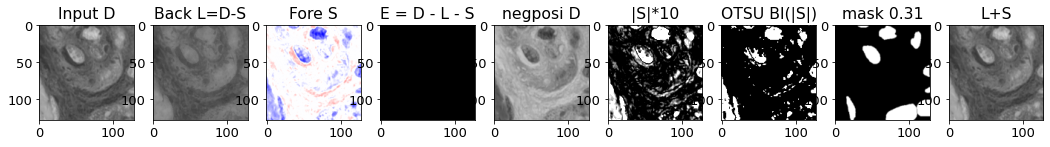

33.0


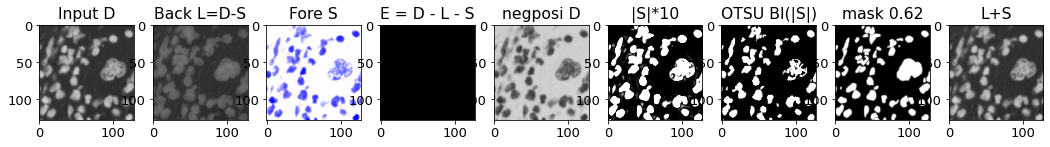

5.0


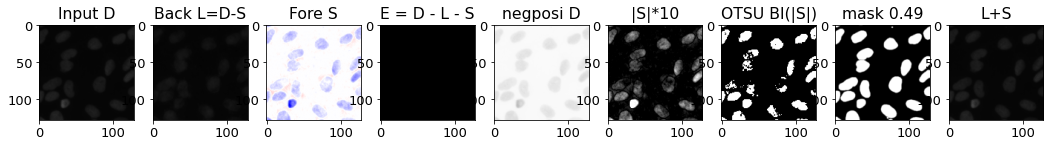

7.0


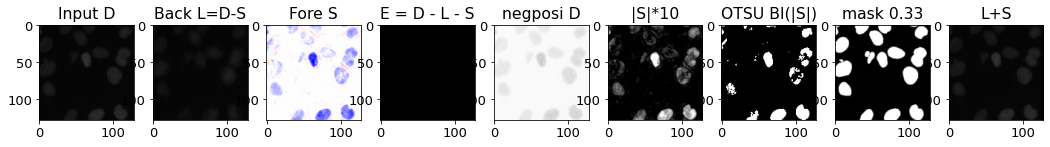

3.0


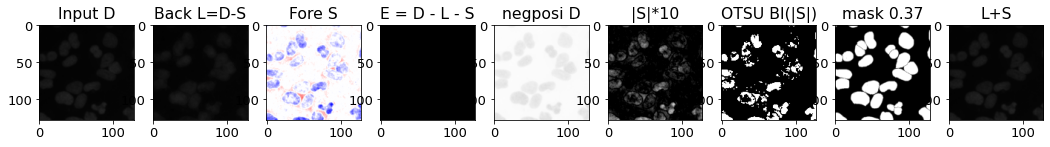

4.0


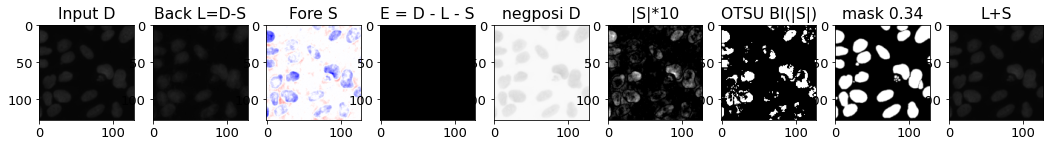

18.0


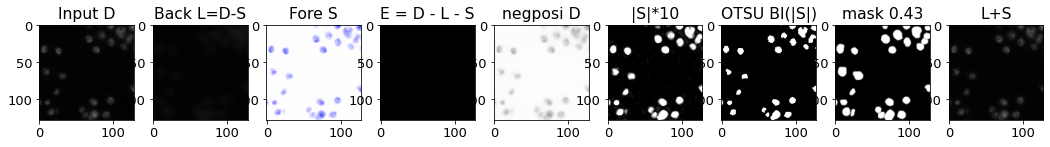

43.0


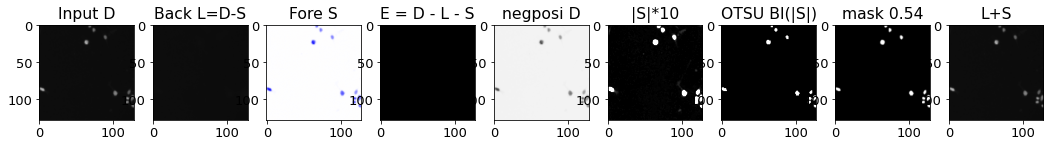

28.0


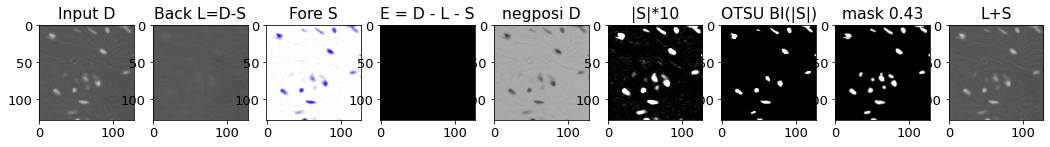

27.0


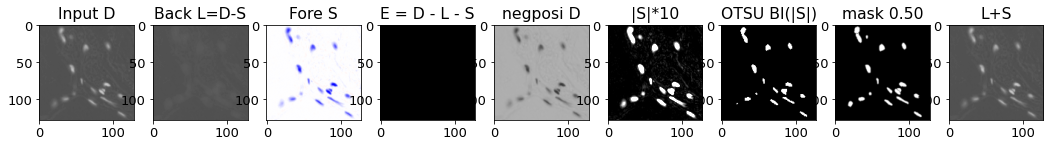

24.0


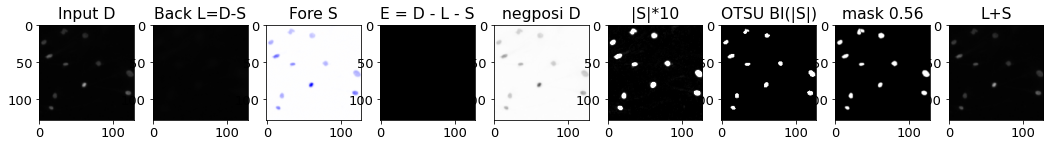

7.0


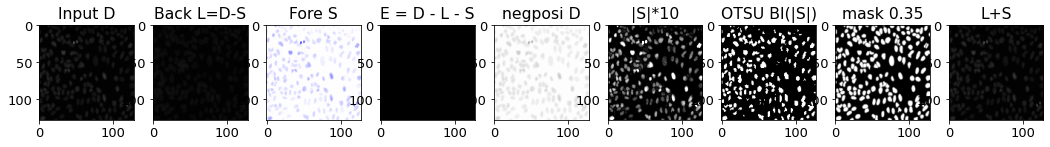

65.0


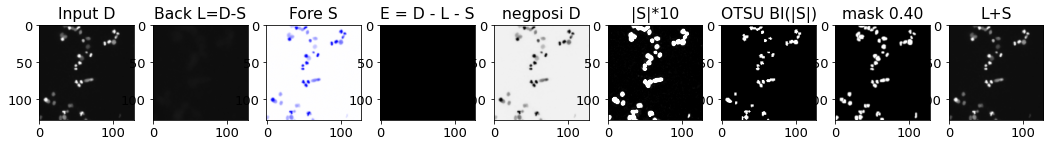

11.0


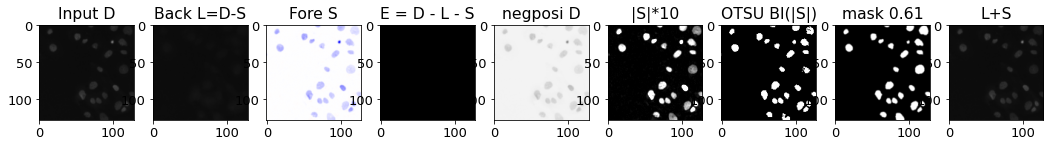

58.0


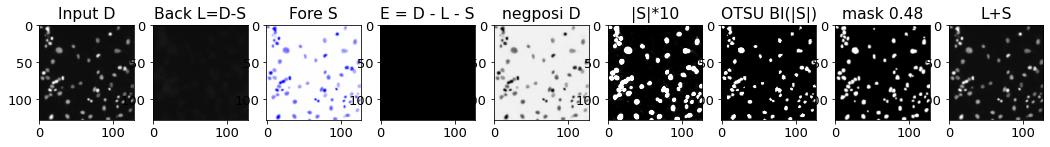

18.0


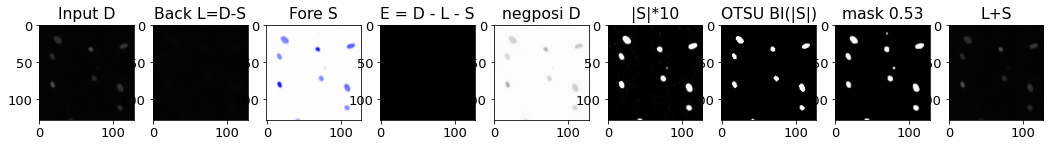

4.0


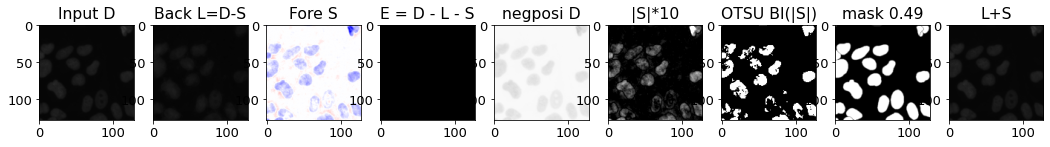

4.0


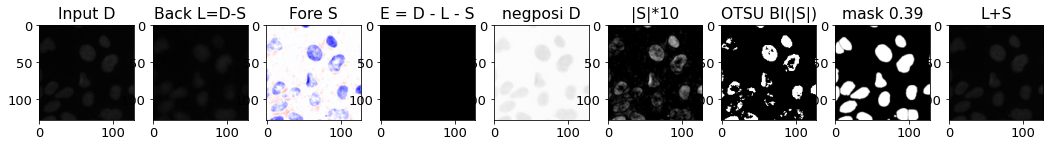

30.0


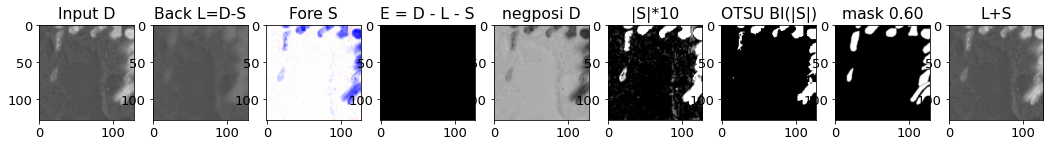

23.0


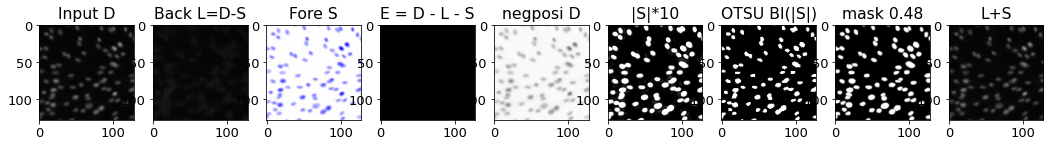

3.0


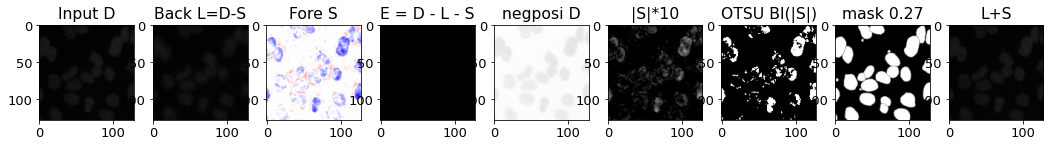

16.0


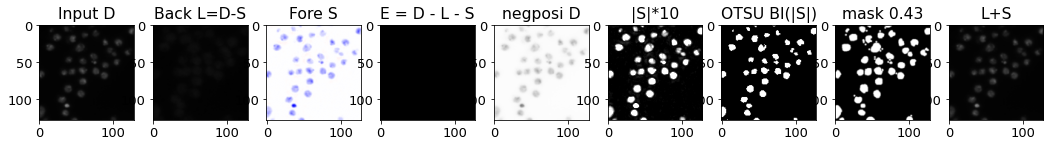

27.0


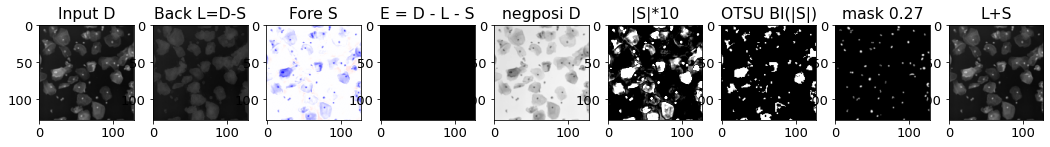

28.0


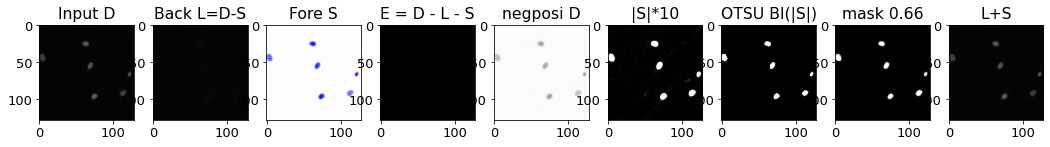

19.0


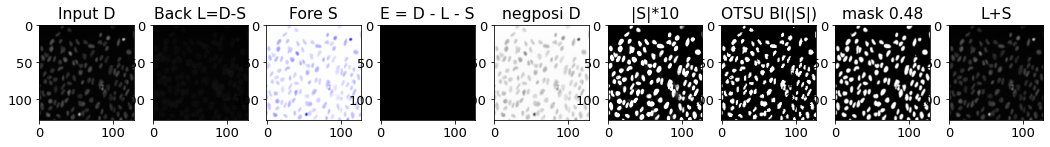

65.0


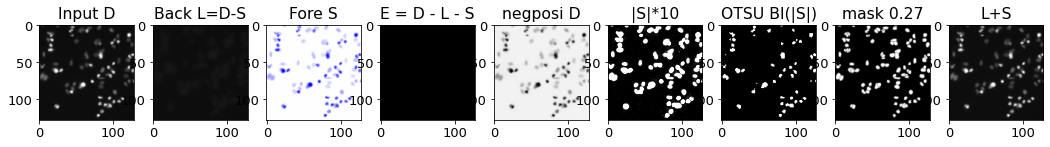

14.0


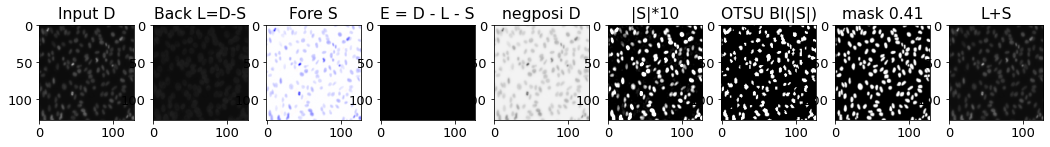

In [281]:
for i in range(30):
  fig, ax = plt.subplots(1, 9, figsize=(18, 8))
  d_img = d[i]
  ax[0].set_title("Input D")
  ax[0].imshow(d_img, cmap="gray", vmin=0, vmax=1)
  l_img = l[i]
  ax[1].set_title("Back L=D-S")
  ax[1].imshow(l_img,  cmap="gray", vmin=0, vmax=1)
  s_img = s[i]
  ax[2].set_title("Fore S")
  ax[2].imshow(toColorImg(s_img), cmap="gray", vmin=0, vmax=1)
  e_img = e[i]
  ax[3].set_title("E = D - L - S")
  ax[3].imshow(e_img, cmap="gray", vmin=0, vmax=1)

  ax[4].set_title("negposi D")
  ax[4].imshow(d_img*-1 + 1, cmap="gray", vmin=0, vmax=1)

  ss_img = np.abs(s_img)
  ax[5].set_title("|S|*10")
  ax[5].imshow(ss_img*10, cmap="gray", vmin=0, vmax=1)

  a, bi = cv2.threshold((ss_img*255).astype(np.uint8), 0, 1, cv2.THRESH_OTSU)
  print(a)
  ax[6].set_title("OTSU BI(|S|)")
  ax[6].imshow(bi, cmap="gray")
  mask = masks[i].clone()
  mask[mask != 0] = 1
  
  ax[7].set_title("mask {:.2f}".format(iou_(torch.tensor(bi), mask)))
  ax[7].imshow(masks[i][0], cmap="gray")
  ax[8].set_title("L+S")
  ax[8].imshow(l_img+s_img, cmap="gray", vmin=0, vmax=1)
  # fig.colorbar(im)
  plt.show()

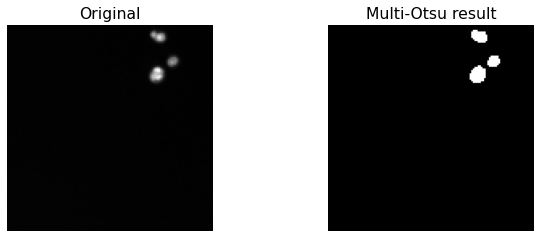

In [266]:
matplotlib.rcParams['font.size'] = 13

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_otsu((imgs[0][0]*255).numpy().astype("uint8"))
# Using the threshold values, we generate the three regions.
mask = torch.zeros((1, 128, 128))
mask[imgs[0]*255 > thresholds/2] = 1
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(imgs[0][0], cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the Multi Otsu result.
ax[1].imshow(mask[0], cmap='gray')
ax[1].set_title('Multi-Otsu result')
ax[1].axis('off')

plt.tight_layout()
plt.savefig('multiotsu.png',dpi=100)
plt.show()

# Unetの学習
畳み込みによるものの影響として、画像内に映るゴミもスパース成分として抽出される。これは、背景にゴミが写っていてもいなくても背景は低ランクとされるためである。

In [ ]:
class UNet(torch.nn.Module):

    def __init__(self, in_channels,conv_channels1,conv_channels2,conv_channels3):
        super().__init__()
        def double_conv(in_channels, out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, 3,padding=1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(out_channels, out_channels, 3,padding=1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU(inplace=True)
            )   
        def last_conv(in_channels,out_channels):
            return torch.nn.Sequential(
                #torch.nn.Conv2d(in_channels, out_channels, 3,padding=1)
                torch.nn.Conv2d(in_channels, out_channels, 1,padding=0)
            )   

        def upsamples(in_channels,out_channels):
            return torch.nn.Sequential(
                torch.nn.Upsample(scale_factor=2,mode = 'bilinear'),
                torch.nn.Conv2d(in_channels, out_channels, 3,padding=1)
            )
        
        self.convs1 = double_conv(in_channels,conv_channels1)
        self.convs2 = double_conv(conv_channels1,conv_channels2)
        self.convs3 = double_conv(conv_channels2,conv_channels3)  
        self.upsample2_S = upsamples(conv_channels3,conv_channels2)
        self.upsample1_S = upsamples(conv_channels2,conv_channels1)
        self.downsample1 = torch.nn.MaxPool2d(2)
        self.downsample2 = torch.nn.MaxPool2d(2)
        self.dconvs2_S = double_conv(conv_channels2 + conv_channels2,conv_channels2)
        self.dconvs1_S = double_conv(conv_channels1 + conv_channels1,conv_channels1)
        self.last_S = last_conv(conv_channels1,in_channels)

    def forward(self, x):

        #down
        convs1 = self.convs1(x)  #x:(B,C,H,W)
        x = self.downsample1(convs1)  #x:(B,C,H,W)
        convs2 = self.convs2(x)       #x:(B,C,H,W)
        x = self.downsample2(convs2)  #x:(B,C,H,W)
        x = self.convs3(x)       #x:(B,C,H,W)
        #up
        fmaps = x
        s = self.upsample2_S(x)  #s:(B,C,H,W)
        s = torch.cat([s, convs2], dim=1) #copy and crop
        s = self.dconvs2_S(s)    #s:(B,C,H,W)
        s = self.upsample1_S(s)  #s:(B,C,H,W)
        s = torch.cat([s, convs1], dim=1) #copy and crop
        s = self.dconvs1_S(s)    #s:(B,C,H,W)
        out_S = self.last_S(s)   #s:(B,C,H,W),out_S:(B,C,H,W)

        return out_S, fmaps

In [ ]:
# val = 10 # If WBC
val = 44 # If BCCD
train = imgs_arr.shape[0] - val
D = {"train": DD[:val*-1].clone().to(device), "val": DD[val*-1:].clone().to(device)}
print(D["train"].shape, D["val"].shape)

ln = 1.
ls = 7.2e-3 # If BCCD
# ls = 8e-3 # If WBC
alpha = 0.5
# Using L1Loss with prox
nucloss = NuclearLoss(lw=torch.tensor(alpha*ln))
l1loss = L1Loss(lw=torch.tensor(alpha*ls))

anucloss = lambda x: torch.sum(torch.svd(x)[1])*alpha*ln
al1loss = lambda x: torch.sum(torch.abs(x)*alpha*ls)

# Random Projection Module
dx, dp = D["train"].shape[1], int(D["train"].shape[1]*0.01)
print(dx, dp)
rp = RandomProjection(dx, dp)

torch.Size([320, 19200]) torch.Size([44, 19200])
19200 192


In [ ]:
# modelUnet = UNet(1,32,64,128).to(device)
#modelUnet = UNet(1,8,16,32,32,16,8).to(device)
modelUnet = UNet(1,16,32,32).to(device)

as_imgseq = {"train":  (1, 1) +  imgs_arr[:val*-1].shape, "val": (1, 1) +  imgs_arr[val*-1:].shape}
# print(as_imgseq)

#as_imgseq = DDseq.shape
#sh = as_imgseq

def model(x, head, batch):
  S, fmaps = modelUnet(x.view(-1, 1, imgs_arr.shape[-2], imgs_arr.shape[-1])[head:head+batch])
  return S.view(batch, -1), fmaps

for phase in ["train", "val"]:
  as_imgseq[phase] = (as_imgseq[phase][2],as_imgseq[phase][0],as_imgseq[phase][3],as_imgseq[phase][4])

  print(as_imgseq[phase])
  print(D[phase].reshape(as_imgseq[phase]).shape)

  # model = lambda x, head, batch: modelUnet(x.view(as_imgseq)[head:head+batch]).view(batch, -1)
  S, fmaps = model(D[phase], 0, 10)
  print(S.shape)
  print(fmaps.shape)

(320, 1, 120, 160)
torch.Size([320, 1, 120, 160])
torch.Size([10, 19200])
torch.Size([10, 32, 30, 40])
(44, 1, 120, 160)
torch.Size([44, 1, 120, 160])
torch.Size([10, 19200])
torch.Size([10, 32, 30, 40])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
lr = {'Adam': 3e-4, 'SGD': 3e-8}      #learning rate


save_net = False
t = time()
# num_iter = 2000
# num_iter = 200
num_iter = 100

display_step = num_iter // 10
history_loss_Unet = []

optimizerM = torch.optim.Adam(modelUnet.parameters(),lr=lr['Adam'])
batch = 80 # If BCCD
# batch = 90 # If WBC

t = time()
for iter in range(num_iter):
  total_loss = 0.
  for i in range(0, D["train"].shape[0], batch):
    # print(i, i+batch)

    S, _ = model(D["train"], i, batch)
    # loss = anucloss(D[i:i+batch]-S[i:i+batch]) + al1loss(S[i:i+batch])
    loss = nucloss(D["train"][i:i+batch]-S) + l1loss(S)
    # loss = nucloss(rp(D["train"][i:i+batch]-S)) + l1loss(S)
    optimizerM.zero_grad()
    loss.backward(retain_graph=True)
    optimizerM.step()
    total_loss += loss.item() / alpha

  history_loss_Unet.append(total_loss)

  if (iter+1) % display_step == 0:
      print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))

print((time()-t)*1000, ' [ms]')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


[ 10/100]: loss = 6907.8711,  
[ 20/100]: loss = 6637.7755,  
[ 30/100]: loss = 6574.3247,  
[ 40/100]: loss = 6540.9932,  
[ 50/100]: loss = 6521.2540,  
[ 60/100]: loss = 6500.5883,  
[ 70/100]: loss = 6489.4478,  
[ 80/100]: loss = 6478.3555,  
[ 90/100]: loss = 6471.9865,  
[100/100]: loss = 6465.8960,  
198338.12808990479  [ms]


train time  
nucloss : RP(1000) : RP(100) = 34991 : 34953 : 34401 [ms]

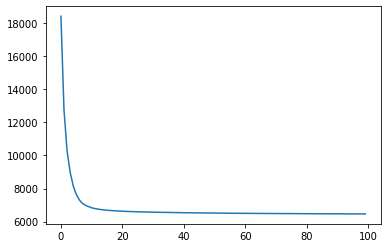

In [ ]:
plt.figure()
plt.plot(history_loss_Unet)
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


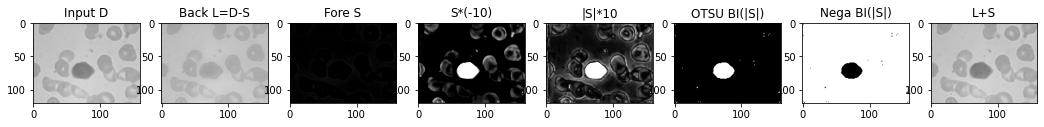

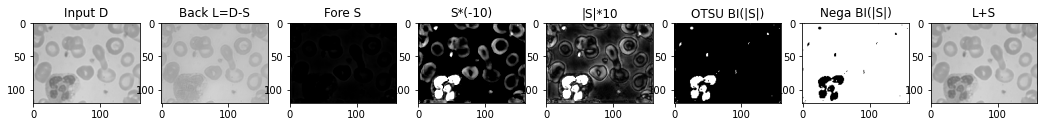

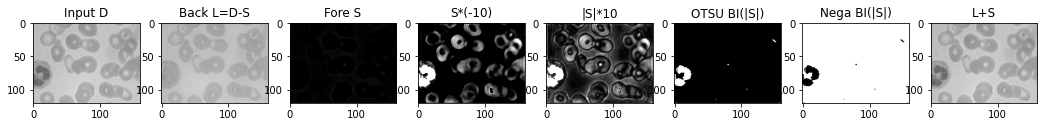

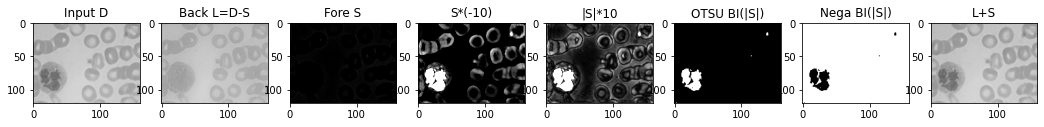

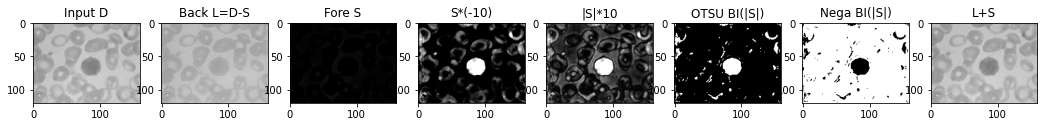

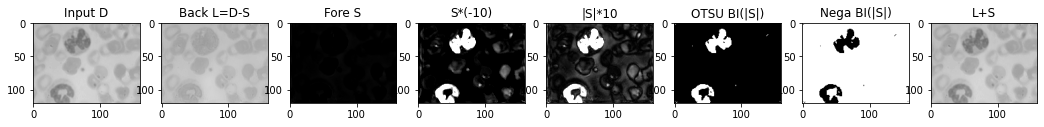

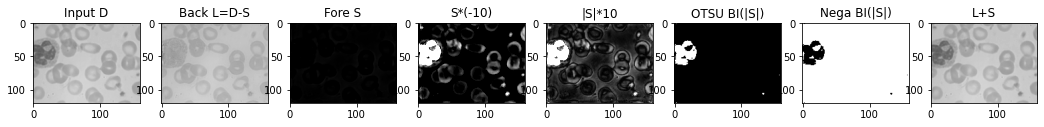

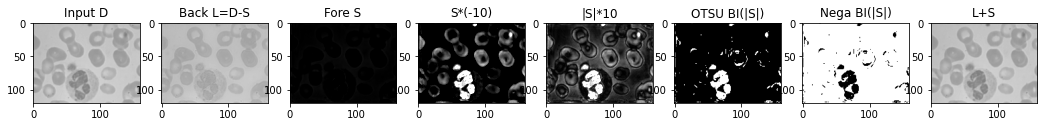

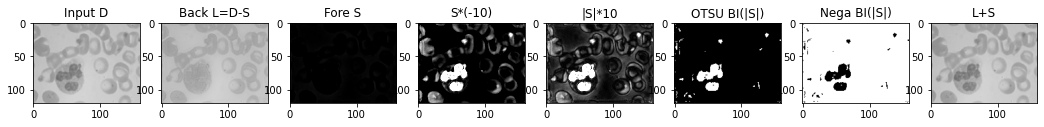

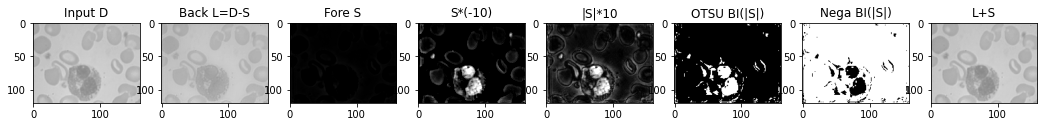

In [ ]:
with torch.no_grad():
    SS, fmaps = model(D["val"], 0, 10)

l = torch.reshape(D["val"][:10]-SS, (-1, imgs[0].shape[0], imgs[0].shape[1])).cpu().data.numpy()
s = torch.reshape(SS, (-1, imgs[0].shape[0], imgs[0].shape[1])).cpu().data.numpy()
d = torch.reshape(D["val"][:10], (-1, imgs[0].shape[0], imgs[0].shape[1])).cpu().data.numpy()


for i in range(10):
  fig, ax = plt.subplots(1, 8, figsize=(18, 8))
  d_img = d[i]
  ax[0].set_title("Input D")
  ax[0].imshow(d_img, cmap="gray", vmin=0, vmax=1)
  l_img = l[i]
  ax[1].set_title("Back L=D-S")
  ax[1].imshow(l_img,  cmap="gray", vmin=0, vmax=1)
  s_img = s[i]
  ax[2].set_title("Fore S")
  ax[2].imshow(s_img, cmap="gray", vmin=0, vmax=1)
  e_img = e[i]

  ax[3].set_title("S*(-10)")
  ax[3].imshow(s_img*-10, cmap="gray", vmin=0, vmax=1)

  ss_img = np.abs(s_img)
  ax[4].set_title("|S|*10")
  ax[4].imshow(ss_img*10, cmap="gray", vmin=0, vmax=1)

  _, bi = cv2.threshold((ss_img*255).astype(np.uint8), 0, 1, cv2.THRESH_OTSU)
  ax[5].set_title("OTSU BI(|S|)")
  ax[5].imshow(bi, cmap="gray")
  ax[6].set_title("Nega BI(|S|)")
  ax[6].imshow(1 - bi, cmap="gray")
  ax[7].set_title("L+S")
  ax[7].imshow(l_img+s_img, cmap="gray", vmin=0, vmax=1)
  # fig.colorbar(im)
  plt.show()

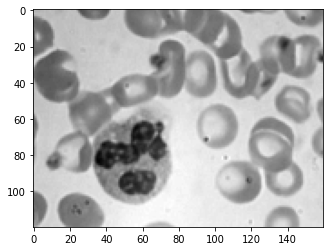

(32, 30, 40)


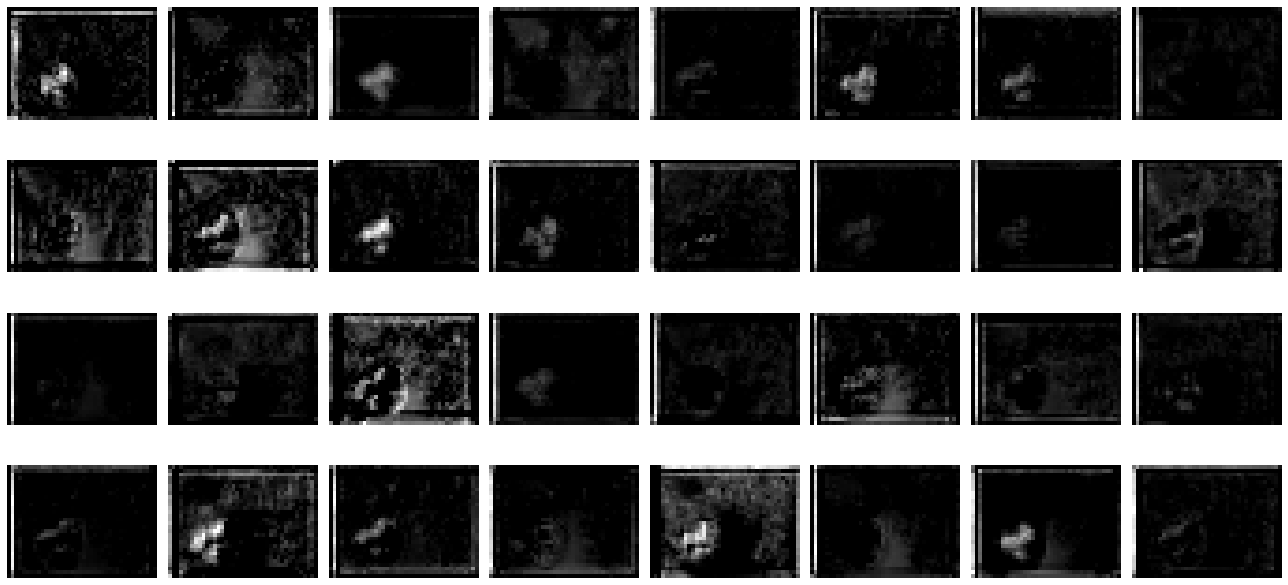

In [ ]:
indice = 8

plt.figure()
plt.imshow(d[indice], cmap="gray")
plt.show()

fmap = fmaps[indice].detach().cpu().numpy()

print(fmap.shape)

fig, ax = plt.subplots(4, 8, figsize=(18, 9), tight_layout=True)

for i, img in enumerate(fmap):
  ax[i//8, i%8].imshow(img, cmap="gray")
  ax[i//8, i%8].axis("off")
plt.show()